# pca autoencoder

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from datasets.clock import get_dataloaders

# PCA Autoencoder

class PCAAutoencoder:
  def __init__(self, n_components):
    self.n_components = n_components
    self.pca = PCA(n_components=n_components)
    self.mean = None

  def fit(self, X):
    self.mean = np.mean(X, axis=0)
    X_centered = X - self.mean
    self.pca.fit(X_centered)
    
  def encoder(self, X):
    X_centered = X - self.mean
    return self.pca.transform(X_centered)
  
  def decoder(self, Z):
    X_reconstructed = self.pca.inverse_transform(Z)
    return X_reconstructed + self.mean


In [3]:
dataloader, _, _, _ = get_dataloaders(batch_size=4096, val_size=0, data_size=4096)
imgs = next(iter(dataloader))[0]
print(imgs.shape)

torch.Size([4096, 1, 128, 128])


(4096, 2)
(4096, 16384)


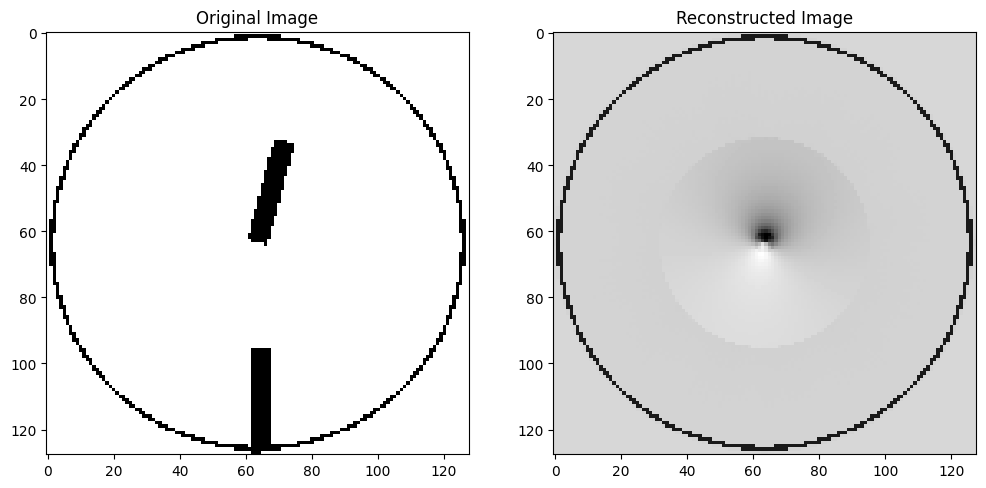

Text(0, 0.5, 'Principal Component 2')

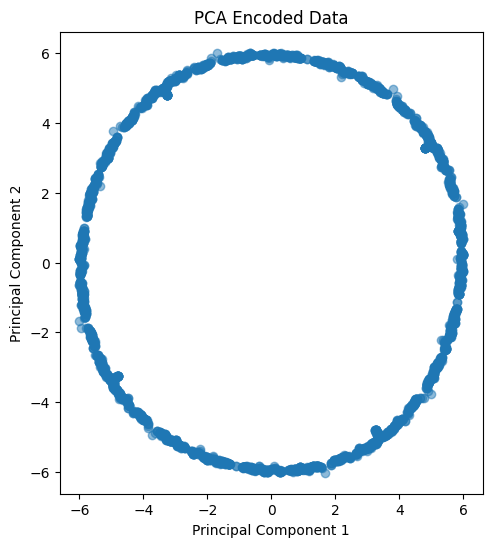

: 

In [ ]:
pca = PCAAutoencoder(n_components=2)
imgs = imgs.reshape(imgs.shape[0], -1)
pca.fit(imgs.numpy())

# Encode
Z = pca.encoder(imgs.numpy())
print(Z.shape)
# Decode
X_reconstructed = pca.decoder(Z)
print(X_reconstructed.shape)

idx = np.random.randint(0, imgs.shape[0])

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imgs[idx].reshape(128, 128), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed[idx].reshape(128, 128), cmap='gray')
plt.title('Reconstructed Image')
plt.show()
# Plot PCA components
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.5)
plt.title('PCA Encoded Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

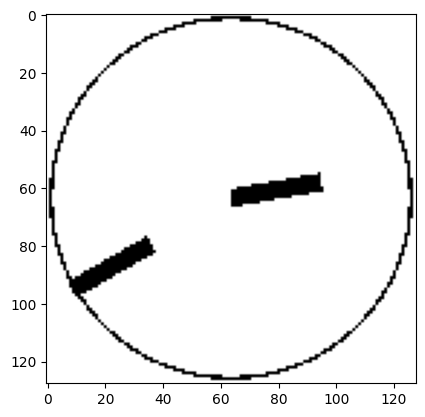

: 

In [6]:
import torch
from dataclasses import dataclass
from datasets.clock import ClockGenerator, ClockConfig, ClockDataset
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE=128

dataset = ClockDataset()

img = dataset.generator.generate_clock_tensor(torch.tensor(2), torch.tensor(40))

plt.imshow(img[0].cpu().numpy(), cmap='gray')


In [1]:
import functools
import numpy as np
import torch.nn as nn
import torch

from models.decoders import ConvResidualDecoderBlock 

class C:
  
  def __init__(self, a=0, b=0, c=0):
    self.a = a
    self.b = b
    self.c = c
    

args = dict(c=3)
c = functools.partial(C, a=1, b=2, **args)

print(c())  


class ConvResidualDecoderBlock3d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=4, stride=2, padding=1, dilation=1):
        super(ConvResidualDecoderBlock3d, self).__init__()
        
        self.upsample1 = nn.Sequential(
          nn.ConvTranspose3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation),
          nn.BatchNorm3d(out_planes),
          nn.LeakyReLU(),
          nn.Conv3d(out_planes, out_planes, kernel_size=3, stride=1, padding=padding, dilation=dilation),
          nn.BatchNorm3d(out_planes),
          nn.LeakyReLU()
        )
        
        self.upsample2 = nn.Sequential(
          nn.ConvTranspose3d(out_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation),
          nn.BatchNorm3d(out_planes),
          nn.LeakyReLU(),
          nn.Conv3d(out_planes, out_planes, kernel_size=3, stride=1, padding=padding, dilation=dilation),
          nn.BatchNorm3d(out_planes),
          nn.LeakyReLU()
        )

        self.skip = nn.Sequential(
            nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=1),
            nn.Upsample(scale_factor=stride**2, mode='nearest'),
            nn.BatchNorm3d(out_planes),
            nn.LeakyReLU()
        )

    def forward(self, x):
        identity = self.skip(x)
        out = self.upsample1(x)
        out = self.upsample2(out)
        out += identity
        return out

img_size = 128
latent_dim=2
dim_before_conv = (2 * img_size) // 128
resnet_start_channels = 128
resnet_start_planes = 64

dim_before_3dconv = 8


fc = nn.Sequential(
    nn.Linear(latent_dim, resnet_start_planes*dim_before_3dconv * dim_before_conv**2), # 2x2 -> 8x8
    nn.ReLU(),
    nn.Unflatten(1, (resnet_start_planes, dim_before_3dconv, dim_before_conv, dim_before_conv)), # 8x8 -> 32x32
)

decoder3d_conv = nn.Sequential(
    ConvResidualDecoderBlock3d(resnet_start_planes, resnet_start_planes // 2),  # 2x2 -> 8x8
    nn.Dropout(0.3),
    ConvResidualDecoderBlock3d(resnet_start_planes // 2, 1),  # 8x8 -> 32x32
    nn.Dropout(0.3),
    nn.Flatten(start_dim=1, end_dim=2),
    nn.ReLU()
)

decoder_conv = nn.Sequential(
    ConvResidualDecoderBlock(resnet_start_channels, resnet_start_channels // 1, convt_strides=[1,1]), #
    nn.Dropout(0.3),
    ConvResidualDecoderBlock(resnet_start_channels // 1, resnet_start_channels // 2, convt_strides=[1,1], dilation=1),  #
    nn.Dropout(0.3),
    ConvResidualDecoderBlock(resnet_start_channels // 2, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.2),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.1),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.1),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.1),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.04),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.01),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 16, convt_strides=[1,1], dilation=1),  # 

    ConvResidualDecoderBlock(resnet_start_channels // 16, resnet_start_channels // 16, convt_strides=[2,2], dilation=1),  #

    nn.Conv2d(resnet_start_channels // 16, 1, kernel_size=3, stride=1, padding=1), # 128x128 -> 128x128
    nn.ReLU()
)

input = torch.randn(64, 2)
out = fc(input)
out = decoder3d_conv(out)
out = decoder_conv(out)

out.shape


torch.Size([64, 1, 128, 128])

: 

In [3]:
%load_ext autoreload
%autoreload 2
from autoencoder.vis import print_model_parameters
from models.classifiers import CNNClassifier, MLPClassifier
from models.decoders import ResNetDecoder3, ResNetDecoder2
from models.encoders import ConvMLPEncoder
from models.autoencoders import MLPResnetAutoencoder
import torch
from functools import partial

# for fc_size, resnet_start_channels in [[8192, 16], [4096, 32], [1900, 64], [600, 128], [180, 256], [100, 384]]:
#     model = partial(ResNetDecoder3,
#       latent_dim=2, 
#       img_size=128, 
#       resnet_start_channels=resnet_start_channels,
#       fc_size=fc_size,
#     )

#     print_model_parameters(
#       model
#     )

IMG_SIZE=64
    
model_partial = partial(MLPResnetAutoencoder,
  encoder_args=dict(
    n_conv_blocks=2,
    channels=[1, 64, 256],
    fc_dims=[256, 128],
  ),
  decoder_args=dict(
    resnet_start_channels=32,
    fc_size=256,
  ),
  img_size=64,
)


# model_partial = partial(
#   CNNClassifier,
# )

print_model_parameters(
  model_partial,
  # details=True
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Layer                                       Param Count
------------------------------------------------------------
------------------------------------------------------------
Total Trainable Parameters                    3,156,625


In [4]:
input_data = torch.randn(64, 1, IMG_SIZE, IMG_SIZE)
model = model_partial()

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    model(input_data)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

out = model(input_data)

/tmp/ipykernel_1922709/1763390051.py:4: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=True) as prof:


--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
               aten::convolution         0.02%     504.267us        42.83%     893.280ms      34.357ms     135.000us         0.01%     891.990ms      34.307ms            26  
              aten::_convolution        10.35%     215.756ms        42.80%     892.694ms      34.334ms     215.574ms        10.33%     891.855ms      34.302ms            26  
                aten::batch_norm         0.01%     154.291us        35.12%     732.405ms      25.255ms     151.000us        

In [ ]:
out

tensor([[[[0.4461, 0.4297, 0.4333,  ..., 0.4056, 0.4139, 0.4272],
          [0.4637, 0.4219, 0.4210,  ..., 0.4058, 0.4076, 0.4326],
          [0.4279, 0.4182, 0.4067,  ..., 0.4173, 0.3971, 0.4304],
          ...,
          [0.4131, 0.4238, 0.4947,  ..., 0.3788, 0.4193, 0.4048],
          [0.4366, 0.4299, 0.4628,  ..., 0.4070, 0.4228, 0.4539],
          [0.4509, 0.4288, 0.4096,  ..., 0.4518, 0.4370, 0.4354]]],


        [[[0.5053, 0.5141, 0.5160,  ..., 0.4186, 0.4317, 0.4101],
          [0.4772, 0.4600, 0.4621,  ..., 0.4147, 0.4133, 0.4217],
          [0.4663, 0.4663, 0.4604,  ..., 0.4106, 0.4266, 0.4269],
          ...,
          [0.4133, 0.4297, 0.5319,  ..., 0.4462, 0.4603, 0.4016],
          [0.4448, 0.4390, 0.4489,  ..., 0.4809, 0.4061, 0.4342],
          [0.4457, 0.4203, 0.3957,  ..., 0.4355, 0.3856, 0.3834]]],


        [[[0.4549, 0.4493, 0.4487,  ..., 0.4214, 0.4278, 0.4256],
          [0.4300, 0.4109, 0.4074,  ..., 0.4141, 0.4197, 0.4266],
          [0.4245, 0.4077, 0.4073,  ..

: 

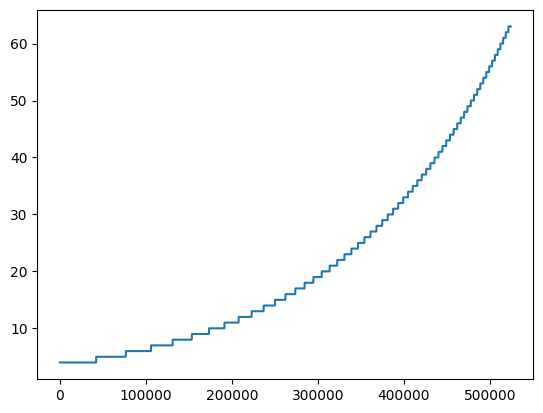

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def scheduler(idx: int, alpha=17, beta=2):
  """
  scheduler
  """
  return int(2**(beta+idx*2**(-1*alpha))) if idx<2**(alpha+2) else None

# plot scheduler from 0 to 2**21
x = np.arange(0, 2**22, 100)
y = [scheduler(i) for i in x]

plt.plot(x, y)
plt.show()

In [3]:
import torch
max_gpus = None
min(max_gpus or torch.cuda.device_count(), torch.cuda.device_count())



4

: 

In [53]:
from decimal import Decimal, getcontext
import math

# Set a high precision (adjust as needed)
getcontext().prec = 100  # Increase if necessary

def mmult(N: int, x: float) -> float:
    # Use high precision Decimal for accurate multiplication
    N_decimal = Decimal(N)
    x_decimal = Decimal(x)
    
    # Compute the product
    result = N_decimal * x_decimal
    
    # Extract the fractional part
    fractional_part = result - result.to_integral_value()
    
    return float(fractional_part)  # Convert back to float if needed

# Example usage with a large N and an irrational number (pi)
N = 10**18
x = math.pi  # Example irrational number

frac_part = mmult(N, x)
print(frac_part)


-0.0020365314558148384


--- 0.023400545120239258 seconds ---


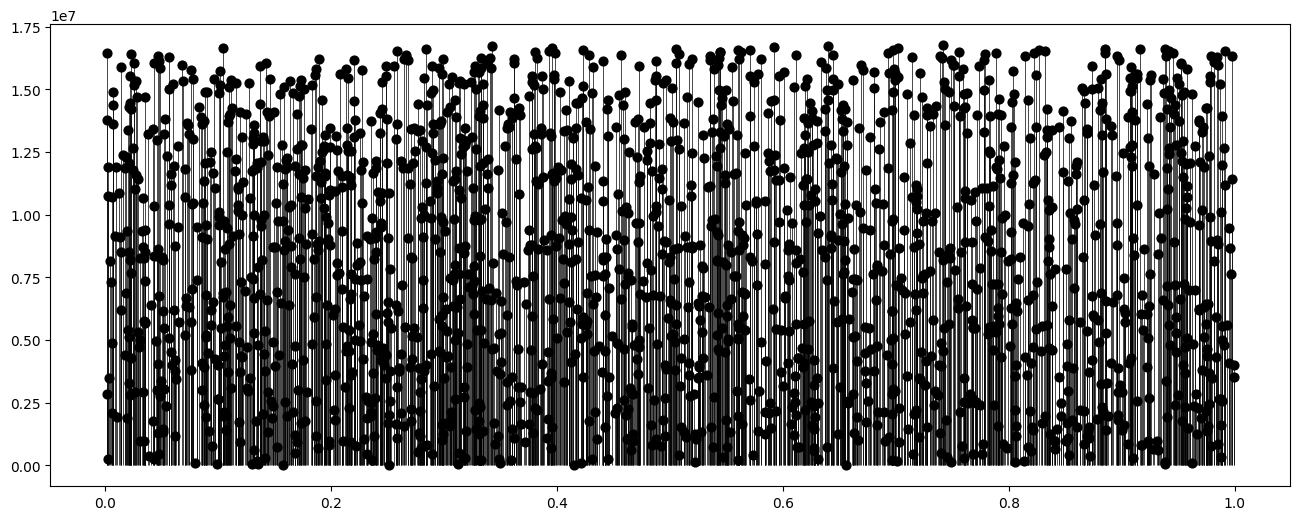

Time of day: 0.993553189560771, Frequency: 1
Time of day: 0.9945384999737144, Frequency: 1
Time of day: 0.9952068589627743, Frequency: 1
Time of day: 0.99558474868536, Frequency: 1
Time of day: 0.9965397175401449, Frequency: 1
Time of day: 0.9973381422460079, Frequency: 1
Time of day: 0.9976429678499699, Frequency: 1
Time of day: 0.9993992038071156, Frequency: 1
Time of day: 0.9994253236800432, Frequency: 1
Time of day: 0.0015595480799674988, Frequency: 1


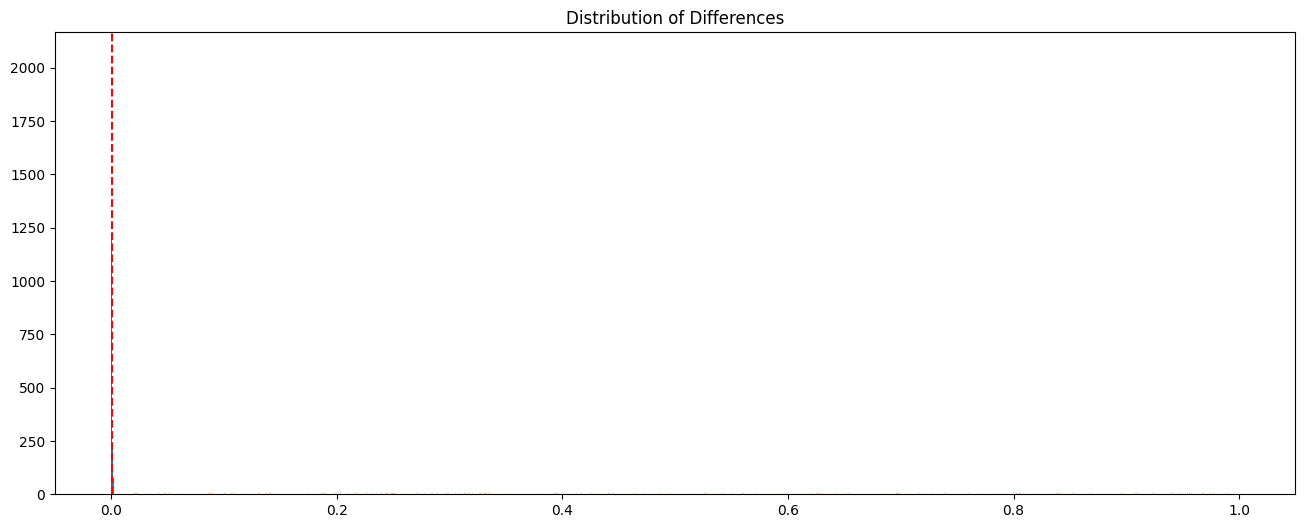

: 

In [73]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline
import time


def f1(idx):
  phi = (1 + np.sqrt(5)) / 2.0 # Golden ratio
  time_of_day = np.modf(phi * idx)[0]
  return time_of_day


def f2(idx):
  phi = (1 + np.sqrt(5)) / 2.0 # Golden ratio
  a = phi * idx
  time_of_day = a - np.floor(a)
  return time_of_day


def f0(idx):
  phi = torch.tensor((1 + np.sqrt(5)) / 2.0, dtype=torch.float64) # Golden ratio
  time_of_day = ( phi * torch.tensor(idx, dtype=torch.float64) ) % 1.0
  return time_of_day


def f3(idx):
    """Returns a pseudo-random value between 0 and 1 using a bitwise hash function."""
    hashed = (idx * 2654435761) & 0xFFFFFFFF  # Multiplying by a large prime number
    return (hashed / 0xFFFFFFFF)
  
N = 2**24
n = 2000

# randomly sample from [0, n)
indices = np.random.randint(0, N, n)

start_time = time.time()
s = [f3(i) for i in indices]
print("--- %s seconds ---" % (time.time() - start_time))

plt.figure(figsize=(16, 6))
plt.scatter(s[:n], indices[:n], alpha=1, c='k', s=40)
plt.vlines(s[:n], 0, indices[:n], alpha=1, color='k', linewidth=0.5)
plt.show()

# sort s and plot distribution of differences, and a vertical line at 1/n_ (mean difference)
s_sorted = np.sort(s[:n])
diffs = np.diff(s_sorted)
plt.figure(figsize=(16, 6))
plt.hist(diffs, bins=100, density=True)
plt.axvline(x=1/n, color='r', linestyle='--', label='1/n')
plt.title('Distribution of Differences')

plt.hist(s, bins=1000, alpha=0.5, linewidth=10);

# Get the top 10 most frequent elements, and their frequencies
unique, counts = np.unique(s, return_counts=True)
top_10_indices = np.argsort(counts)[-10:]
top_10_times = unique[top_10_indices]
top_10_counts = counts[top_10_indices]
# Print the top 10 most frequent elements and their frequencies
for i in range(len(top_10_times)):
    print(f'Time of day: {top_10_times[i]}, Frequency: {top_10_counts[i]}')

In [ ]:
%load_ext autoreload
%autoreload 2

from datasets.clock import ClockDatasetConfig, ClockConfig
from datasets.clock import get_dataloaders
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch

N = 2**24
n = 4096

BATCH_SIZE = 256
train_dataloader, val_dataloader, train_sampler, _ = get_dataloaders(
    data_config=ClockConfig(
          hour_hand_width=0.1,
          minute_hand_width=0.075,
          minute_hand_start=1/3,
        ),
    dataset_config=ClockDatasetConfig(
          data_size=N,
          augment=dict(
            noise_std=0.01,
            # blur=1.0
          ),
          img_size=64,
        ),
    batch_size=256,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
def get_time0(idx):
  phi = torch.tensor((1 + np.sqrt(5)) / 2.0, dtype=torch.float32) # Golden ratio
  time_of_day = ( phi * torch.tensor(idx, dtype=torch.float32) ) % 1.0
  return time_of_day


def get_time(idx):
  phi = torch.tensor((1 + np.sqrt(5)) / 2.0, dtype=torch.float64) # Golden ratio
  time_of_day = ( phi * torch.tensor(idx, dtype=torch.int32) ) % 1.0
  return time_of_day


[ 1060805 16014810  1817316 ...   486834  2239141 12269521]
Time of day: 0.33699692972004414, Frequency: 1
Time of day: 0.33713543601334095, Frequency: 1
Time of day: 0.3371505830436945, Frequency: 1
Time of day: 0.33735015615820885, Frequency: 1
Time of day: 0.3379167206585407, Frequency: 1
Time of day: 0.33804926648736, Frequency: 1
Time of day: 0.3385620079934597, Frequency: 1
Time of day: 0.338773500174284, Frequency: 1
Time of day: 0.3388663437217474, Frequency: 1
Time of day: 0.31377120316028595, Frequency: 2
total samples: 4096


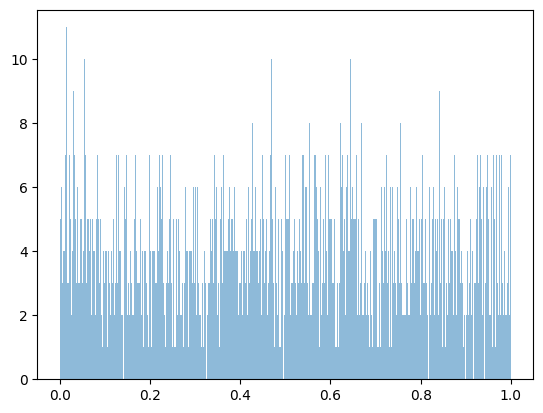

In [ ]:

times = []

# for i, data in tqdm(enumerate(train_dataloader)):
#   times.append(data[3].numpy())
#   if i > n_/BATCH_SIZE:
#     break
# times = np.concatenate(times)

  
indices = np.random.randint(0, N, n)
print(indices)

times = [get_time(i).numpy() for i in indices]



    
print(f"total samples: {len(times)}")

#   img = data[0][0]
#   plt.figure()
#   plt.imshow(img[0].numpy(), cmap='gray')
#   plt.title(f'Time of day {data[3][0]}')


In [10]:
import torch
import numpy 